![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt


In [7]:
# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [8]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [9]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [10]:
# Celda 1
# Estadísticas descriptivas
print("Estadísticas descriptivas - Variables numéricas:")
print(data.describe())

Estadísticas descriptivas - Variables numéricas:
              Price          Year        Mileage       M_Camry    M_Camry4dr  \
count  10495.000000  10495.000000   10495.000000  10495.000000  10495.000000   
mean   14538.403716   2013.553883   52509.430395      0.056313      0.158456   
std     3922.420961      3.116585   36791.736601      0.230535      0.365186   
min     5002.000000   1998.000000       5.000000      0.000000      0.000000   
25%    11999.000000   2012.000000   26461.000000      0.000000      0.000000   
50%    15000.000000   2014.000000   41680.000000      0.000000      0.000000   
75%    16999.000000   2016.000000   71355.500000      0.000000      0.000000   
max    32444.000000   2018.000000  232658.000000      1.000000      1.000000   

        M_CamryBase      M_CamryL     M_CamryLE     M_CamrySE    M_CamryXLE  
count  10495.000000  10495.000000  10495.000000  10495.000000  10495.000000  
mean       0.012292      0.048213      0.236494      0.376370      0.11186

In [11]:
# Arbol Manual
# Función para calcular la reducción de la varianza
def variance_reduction(y, y_left, y_right):
    var_total = np.var(y)
    var_left = np.var(y_left)
    var_right = np.var(y_right)
    
    weight_left = len(y_left) / len(y)
    weight_right = len(y_right) / len(y)
    
    return var_total - (weight_left * var_left + weight_right * var_right)

# Función para encontrar la mejor división
def best_split(X, y):
    best_feature = None
    best_threshold = None
    best_gain = -np.inf

    for feature in X.columns:
        thresholds = X[feature].unique()
        for threshold in thresholds:
            left_indices = X[feature] <= threshold
            right_indices = X[feature] > threshold

            y_left = y[left_indices]
            y_right = y[right_indices]

            if len(y_left) > 0 and len(y_right) > 0:
                gain = variance_reduction(y, y_left, y_right)
                if gain > best_gain:
                    best_feature = feature
                    best_threshold = threshold
                    best_gain = gain

    return best_feature, best_threshold, best_gain

# Función para construir el árbol recursivamente
def build_tree(X, y, depth=0, max_depth=3):
    if depth == max_depth or len(y) <= 1:
        return {'prediction': y.mean()}

    feature, threshold, gain = best_split(X, y)

    if gain == 0:
        return {'prediction': y.mean()}

    left_indices = X[feature] <= threshold
    right_indices = X[feature] > threshold

    left_tree = build_tree(X[left_indices], y[left_indices], depth + 1, max_depth)
    right_tree = build_tree(X[right_indices], y[right_indices], depth + 1, max_depth)

    return {
        'feature': feature,
        'threshold': threshold,
        'left': left_tree,
        'right': right_tree
    }

# Construir el árbol
tree = build_tree(X_train, y_train, max_depth=3)

# Función para hacer predicciones
def predict(tree, X):
    if 'prediction' in tree:
        return tree['prediction']

    feature = tree['feature']
    threshold = tree['threshold']

    if X[feature] <= threshold:
        return predict(tree['left'], X)
    else:
        return predict(tree['right'], X)

# Hacer predicciones en el conjunto de prueba
predictions = X_test.apply(lambda x: predict(tree, x), axis=1)

# RMSE y MAE
rmse_mt = np.sqrt(mean_squared_error(y_test, predictions))
mae_mt = mean_absolute_error(y_test, predictions)

print("Arbol Manual:")
tree

Arbol Manual:


{'feature': 'Year',
 'threshold': 2012,
 'left': {'feature': 'Year',
  'threshold': 2011,
  'left': {'feature': 'Mileage',
   'threshold': 99121,
   'left': {'prediction': 9869.941007194244},
   'right': {'prediction': 7704.2112860892385}},
  'right': {'feature': 'Mileage',
   'threshold': 82133,
   'left': {'prediction': 13524.848942598188},
   'right': {'prediction': 11089.767567567567}}},
 'right': {'feature': 'Year',
  'threshold': 2016,
  'left': {'feature': 'Mileage',
   'threshold': 49121,
   'left': {'prediction': 16302.402676399026},
   'right': {'prediction': 14004.804278074866}},
  'right': {'feature': 'M_CamryXLE',
   'threshold': 0,
   'left': {'prediction': 18798.41562064156},
   'right': {'prediction': 21800.491525423728}}}}

In [12]:
# RMSE y MAE
print("El RMSE del Árbol Manual es: ",rmse_mt)
print("El MAE del Árbol Manual es: ",mae_mt)

El RMSE del Árbol Manual es:  1935.1155006739664
El MAE del Árbol Manual es:  1458.0246928139518


### Conclusión del punto 1

Análisis de Resultados del Árbol de Decisión Manual
RMSE - Media del Precio:
El RMSE del árbol de decisión manual es 1,935.12, lo que representa aproximadamente el 13.31% (1,935.12 / 14,538.40) de la media del precio (14,538.40). El  porcentaje nos indica que el modelo tiene en general presenta ajuste adecuado.

RMSE - Desviación Estándar del Precio:
La desviación estándar del precio (3,922.42), el RMSE es aproximadamente el 49.33% (1,935.12 / 3,922.42). Nos indica que el modelo tiene precisión aceptable que se puede mejorar, ya que el RMSE debería ser menor en comparación con la varianza normal de la informacion.

MAE - Media del Precio:
El MAE del árbol de decisión manual 1,458.02, lo que equivale aproximadamente al 10.03% (1,458.02 / 14,538.40) del promedio del precio. Los errores en las predicciones son realitvamente bajos. Como modelo inicial es adecuado.

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [13]:
# Celda 2
# Bagging Manual
# Crear muestras bootstrap
np.random.seed(123)
n_samples = X_train.shape[0]
n_trees = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_trees)]

# Entrenar 10 árboles de decisión en las muestras bootstrap
trees = []
for sample in samples:
    X_sample = X_train.iloc[sample]
    y_sample = y_train.iloc[sample]
    tree = DecisionTreeRegressor(random_state=123)
    tree.fit(X_sample, y_sample)
    trees.append(tree)

# Hacer predicciones promedio en el conjunto de prueba
predictions = np.zeros(X_test.shape[0])
for tree in trees:
    predictions += tree.predict(X_test)
predictions /= n_trees

# RMSE y MAE
rmse_bm = np.sqrt(mean_squared_error(y_test, predictions))
mae_bm = mean_absolute_error(y_test, predictions)

# RMSE y MAE
print("El RMSE del Bagging Manual es: ",rmse_bm)
print("El MAE del Bagging Manual es: ",mae_bm)

El RMSE del Bagging Manual es:  1796.4355868399332
El MAE del Bagging Manual es:  1340.0160739030025


### Conclusión del punto 2

Análisis de Resultados del modelo Bagging Manual

RMSE - Media del Precio:
El RMSE  es de 1796,44 (12,36 % del precio promedio = 14 538,40) y es mejor que el Árbol de Decisión Manual (1935,12). RMSE del precio estándar = 3922,42 (Es mejor que el Árbol de Decisión Manual). MAE = 1340,02 (9,22 % del precio promedio) y es mejor que el Árbol de Decisión Manual (1458,02).

MAE - Media del Precio:

El MAE del método manual de Bagging es de 1340,02 y el MAE del árbol de decisión manual es de 1458,02, lo que mejora la precisión del método manual de Bagging.

Conclusion General
Ambos modelos tienen un error (RMSE y MAE) menor que la mitad de la desviación estándar del precio, lo que indica que ambos son modelos aceptables y, sin embargo, Bagging Manual es mejor que el Arbol Manual en términos de RMSE y MAE, porque Bagging Manual es mejor para capturar el cambio en el precio del automóvil.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [14]:
# Celda 3

bagging_model_library = BaggingRegressor(
    DecisionTreeRegressor(),
    n_estimators=10,  # Número de árboles
    random_state=1,
    n_jobs=-1,
    # max_features='log2'
)

# Entrenar y evaluar
bagging_model_library.fit(X_train, y_train)
y_pred = bagging_model_library.predict(X_test)

# RMSE y MAE
rmse_bl = np.sqrt(mean_squared_error(y_test, y_pred))
mae_bl = mean_absolute_error(y_test, y_pred)

# RMSE y MAE
print("El RMSE del Bagging libreria es: ",rmse_bl)
print("El MAE del Bagging libreria es: ",mae_bl)

El RMSE del Bagging libreria es:  1786.4086682967377
El MAE del Bagging libreria es:  1332.396452032699


### Conclusión del punto 3

Si bien la desviación estándar es de aproximadamente 3900 dólares, un modelo con un RMSE de 1786 podría considerarse aceptable. Sin embargo, esta evaluación puede reconsiderarse al observar que el precio del vehículo más económico es de 5000 dólares. Además, si se toma como referencia el percentil 25, donde el 25 % de los vehículos tienen un valor inferior a 12.000 dólares, el RMSE de 1786 sigue siendo relativamente alto en relación con los precios más bajos.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [15]:
# Celda 4
rf_model = RandomForestRegressor(
    n_estimators=10,   # Número de árboles (default=100)
    max_features='log2',
    random_state=1,    # Semilla para reproducibilidad
    n_jobs=-1          # Usar todos los núcleos del CPU
)

# Entrenar el modelo
rf_model.fit(X_train, y_train)

# Predecir y evaluar
y_pred = rf_model.predict(X_test)

# RMSE y MAE
rmse_rfl = np.sqrt(mean_squared_error(y_test, y_pred))
mae_rfl = mean_absolute_error(y_test, y_pred)

# RMSE y MAE
print("El RMSE del Random Forest es: ",rmse_rfl)
print("El MAE del Random Forest es: ",mae_rfl)

El RMSE del Random Forest es:  1818.718070815367
El MAE del Random Forest es:  1358.6143693867075


### Conclusión del punto 4

Como punto de comparación inicial nos damos cuenta que presenta un peor desempeño que el bagging por librería teniendo en cuenta las mismas consideraciones mencionadas en el punto anterior.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

### Numero de estimadores

In [16]:
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 300, 10)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
rmse = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    rfr = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    rmse.append(cross_val_score(rfr, X, y, cv=5, scoring='r2').mean())

print(rmse)

[0.7963294473153648, 0.7995680579677734, 0.8012049484925179, 0.801851157899969, 0.8017033014904842, 0.8021111826362611, 0.8022066379543563, 0.8022823196714196, 0.802243602732611, 0.8022072907461739, 0.802394971593414, 0.8023436687508235, 0.8024618135754663, 0.8026395592617369, 0.8026714897493614, 0.8026287718953068, 0.8025830725096552, 0.8025805303826612, 0.8025993394197084, 0.8026025149335915, 0.802515228771678, 0.8025197594896799, 0.8025636864423991, 0.802611525390852, 0.8027076183420349, 0.8027484640713063, 0.8027066014891734, 0.8027271410373749, 0.8027429285531534]


Text(0, 0.5, 'r2')

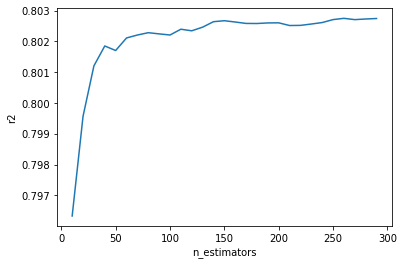

In [17]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, rmse)
plt.xlabel('n_estimators')
plt.ylabel('r2')

#### Max features

In [18]:
features_cols = X.columns
features_cols

Index(['Year', 'Mileage', 'M_Camry', 'M_Camry4dr', 'M_CamryBase', 'M_CamryL',
       'M_CamryLE', 'M_CamrySE', 'M_CamryXLE'],
      dtype='object')

In [19]:
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, len(features_cols)+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
accuracy_scores = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    clf = RandomForestRegressor(n_estimators=200, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='r2').mean())

Text(0, 0.5, 'r2')

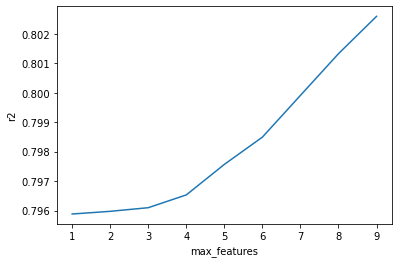

In [20]:
# Gráfica del desempeño del modelo vs la cantidad de max_features
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('r2')

In [21]:
# Celda 5
# Definición del modelo con los parámetros max_features=6 y n_estimators=200 
rfc = RandomForestRegressor(n_estimators=250, max_features=9, random_state=1, n_jobs=-1)
rfc.fit(X, y)
# Impresión de resultados de desemepeño del modelo
pd.DataFrame({'feature':features_cols, 'importance':rfc.feature_importances_}).sort_values('importance')

,feature,importance
4,M_CamryBase,0.000481
3,M_Camry4dr,0.001090
5,M_CamryL,0.001189
7,M_CamrySE,0.004732
2,M_Camry,0.006614
6,M_CamryLE,0.009499
8,M_CamryXLE,0.015094
1,Mileage,0.257092
0,Year,0.704208


In [22]:
# Predecir y evaluar
y_pred = rfc.predict(X_test)

# RMSE y MAE
rmse_rfc = np.sqrt(mean_squared_error(y_test, y_pred))
mae_rfc = mean_absolute_error(y_test, y_pred)

# RMSE y MAE
print("El RMSE del Random Forest calibrado es: ",rmse_rfc)
print("El MAE del Random Forest calibrado es: ",mae_rfc)

El RMSE del Random Forest calibrado es:  664.1726301631827
El MAE del Random Forest calibrado es:  490.6943767910588


### Conclusión del punto 5

Tomando de nuevo la desviacion estandar  3900 dólares, comparandola con el RMSE de 664 podría considerarse bastante aceptable. Y haciendo una segunda  evaluación el percentil 25, donde el 25 % de los vehículos tienen un valor inferior a 12.000 dólares, el RMSE de 664 sigue siendo bastante bajo lo que hace este modelo mucho más útil.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modulo

In [23]:
!pip install xgboost

# Celda 6
import warnings
warnings.filterwarnings('ignore')

# Importación de librerías
%matplotlib inline
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [24]:
# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Creación y entrenamiento del modelo XGBoost
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',  # Para regresión
    n_estimators=100,              # Número de árboles
    learning_rate=0.1,            # Tasa de aprendizaje
    max_depth=5,                  # Profundidad máxima
    random_state=42               # Semilla para reproducibilidad
)

# Entrenamiento del modelo
xgb_model.fit(X_train, y_train)

# Predicciones
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

# Evaluación del modelo
train_rmse_xboost = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse_xboost = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

# Impresión de resultados
print("Resultados del modelo XGBoost:")
print(f"RMSE en entrenamiento: {train_rmse_xboost:.2f}")
print(f"RMSE en prueba: {test_rmse_xboost:.2f}")
print(f"R2 en entrenamiento: {train_r2:.4f}")
print(f"R2 en prueba: {test_r2:.4f}")

# Importancia de características
feature_importance = xgb_model.feature_importances_
feature_names = X.columns

# Mostrar importancia de características
print("\nImportancia de las características:")
for name, importance in zip(feature_names, feature_importance):
    print(f"{name}: {importance:.4f}")

Resultados del modelo XGBoost:
RMSE en entrenamiento: 1386.12
RMSE en prueba: 1547.19
R2 en entrenamiento: 0.8754
R2 en prueba: 0.8435

Importancia de las características:
Year: 0.7117
Mileage: 0.0896
M_Camry: 0.0452
M_Camry4dr: 0.0085
M_CamryBase: 0.0054
M_CamryL: 0.0125
M_CamryLE: 0.0420
M_CamrySE: 0.0113
M_CamryXLE: 0.0738


### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [25]:
# Celda 7
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Optimizar tipos de datos
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

# Definición del modelo base
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=5,
    random_state=42
)

# Definición de la cuadrícula de parámetros a calibrar
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'gamma': [0, 0.1, 1],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Configuración de GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=2  # Usar 2 núcleos
)

# Entrenamiento con búsqueda de parámetros
grid_search.fit(X_train, y_train)

# Mejores parámetros encontrados
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

# Entrenamiento del modelo con los mejores parámetros
best_xgb_model = grid_search.best_estimator_

# Predicciones
y_pred_test = best_xgb_model.predict(X_test)

# Cálculo de métricas
rmse_xboost_calibrado = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_xboost_calibrado = mean_absolute_error(y_test, y_pred_test)

# Resultados
print('\nDesempeño del modelo XGBoost calibrado:')
print(f'RMSE: {rmse_xboost_calibrado:.2f}')
print(f'MAE: {mae_xboost_calibrado:.2f}')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mejores parámetros encontrados:
{'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.1}

Desempeño del modelo XGBoost calibrado:
RMSE: 1538.00
MAE: 1129.74


### Conclusión del punto 7

El modelo XGBoost calibrado muestra un desempeño optimizado tras la búsqueda de hiperparámetros.
Los valores de RMSE y MAE reflejan la capacidad del modelo para predecir precios con mayor precisión.

Efecto de los parámetros:
- Learning_rate: Controla la contribución de cada árbol. Valores bajos (e.g., 0.01) hacen el aprendizaje más lento y preciso, pero requieren más árboles.
- Gamma: Especifica la reducción mínima de pérdida para crear una partición. Valores altos (e.g., 1) hacen el modelo más conservador.
- Colsample_bytree: Determina la fracción de características usadas por árbol. Valores menores (e.g., 0.6) aumentan la regularización y reducen el sobreajuste.


### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

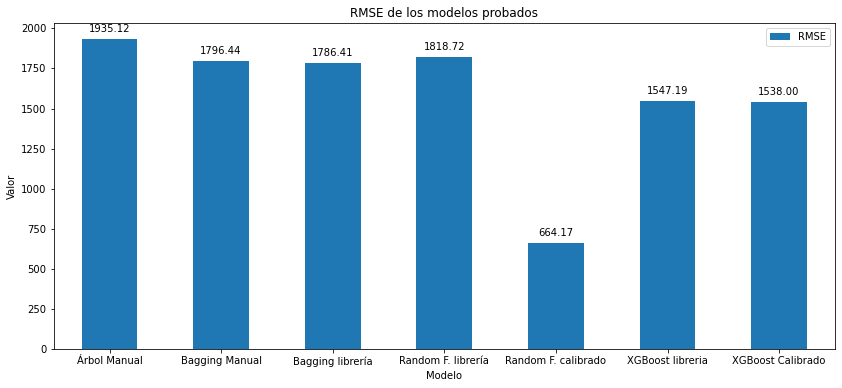

In [32]:
# Celda 8
# Datos
data = {
    'Modelo': ['Árbol Manual', 'Bagging Manual','Bagging librería', 'Random F. librería', 'Random F. calibrado','XGBoost libreria','XGBoost Calibrado' ],
    'RMSE': [rmse_mt, rmse_bm, rmse_bl,rmse_rfl, rmse_rfc,test_rmse_xboost,rmse_xboost_calibrado]
}

df_resultados = pd.DataFrame(data)

# Gráfica de barras
ax = df_resultados.plot(x='Modelo', kind='bar', figsize=(14, 6), rot=0)
plt.title('RMSE de los modelos probados')
plt.ylabel('Valor')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

### Conclusiones:
Todos los modelos presentaron un rendimiento similar, mostrando entre ellos un mejor rendimiento los XGBoost, sin embargo, el modelo que mejor se desempeña es el segundo modelo de Random Forest que respondió mejor a la calibración. Se evidencia que el modelo de árbol manual tuvo un RMSE más alto, esto es esperado ya que un árbol de decisión simple tiende a sobre ajustarse al no encontrar patrones complejos. Los modelos de bagging tienen un RMSE similar al de random forest, pero mucho más alto que random forest calibrado. esto sugiere que sin calibración random forest no ofrece una ventaja significativa sobre bagging en este caso en particular. Aunque XGboost es conocido por su alto rendimiento en muchos problemas, en este caso random forest calibrado lo supera, esto podría deberse a que el conjunto de datos contiene características que lo favorecen, como relaciones entre variables más lineales.